In [1]:
#利用svm解决国际象棋里面的是否兵与王的问题，从而达到预测白方获胜或者是和棋（三个棋子在棋盘的位置决定的）
#步骤1 数据的导入以及处理
#步骤2 训练样本
#步骤3 调参
#步骤4 ROC曲线判断泛化能力

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/krkopt/krkopt.data


In [3]:
import pandas as pd
import numpy as np

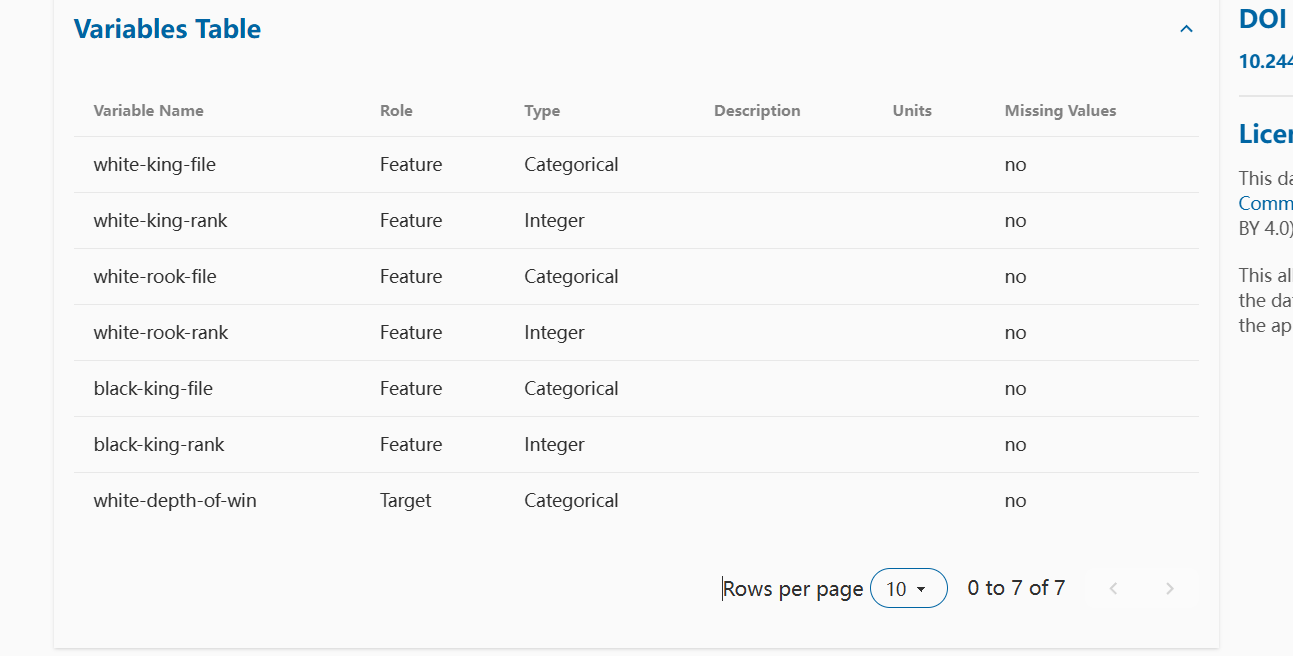

In [4]:
column=['white-king-file','white-king-rank','white-rook-file','white-rook-rank','black-king-file','black-king-rank','white-depth-of-win']

In [5]:
df=pd.read_csv('/kaggle/input/krkopt/krkopt.data',header=0,sep=',',names=column)
df


,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,a,1,c,1,c,2,draw
1,a,1,c,1,d,1,draw
2,a,1,c,1,d,2,draw
3,a,1,c,2,c,1,draw
4,a,1,c,2,c,3,draw
...,...,...,...,...,...,...,...
28050,b,1,g,7,e,5,sixteen
28051,b,1,g,7,e,6,sixteen
28052,b,1,g,7,e,7,sixteen
28053,b,1,g,7,f,5,sixteen


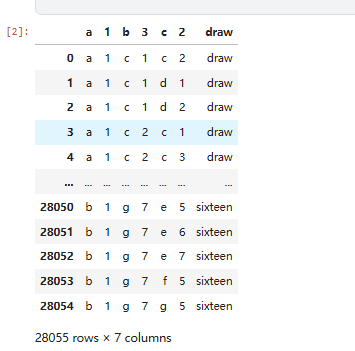
不难发现我们必须要加一个columns，以取代表头


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28055 entries, 0 to 28054
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   white-king-file     28055 non-null  object
 1   white-king-rank     28055 non-null  int64 
 2   white-rook-file     28055 non-null  object
 3   white-rook-rank     28055 non-null  int64 
 4   black-king-file     28055 non-null  object
 5   black-king-rank     28055 non-null  int64 
 6   white-depth-of-win  28055 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.5+ MB


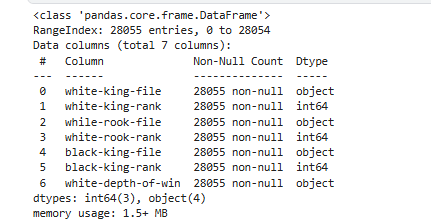
这里看出没有缺失值

In [7]:
df.describe()

,white-king-rank,white-rook-rank,black-king-rank
count,28055.000000,28055.000000,28055.000000
mean,1.854037,4.512458,4.451898
std,0.926417,2.282746,2.248379
min,1.000000,1.000000,1.000000
25%,1.000000,3.000000,3.000000
50%,2.000000,5.000000,4.000000
75%,2.000000,6.000000,6.000000
max,4.000000,8.000000,8.000000


In [8]:
#下面的操作就是利用apply函数将draw表示0代表的是和棋其余的都代表白方获胜
df['win_draw'] = df['white-depth-of-win'].apply(lambda x: 0 if x == "draw" else 1)
df=df.drop('white-depth-of-win',axis=1)


In [9]:
df

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,win_draw
0,a,1,c,1,c,2,0
1,a,1,c,1,d,1,0
2,a,1,c,1,d,2,0
3,a,1,c,2,c,1,0
4,a,1,c,2,c,3,0
...,...,...,...,...,...,...,...
28050,b,1,g,7,e,5,1
28051,b,1,g,7,e,6,1
28052,b,1,g,7,e,7,1
28053,b,1,g,7,f,5,1


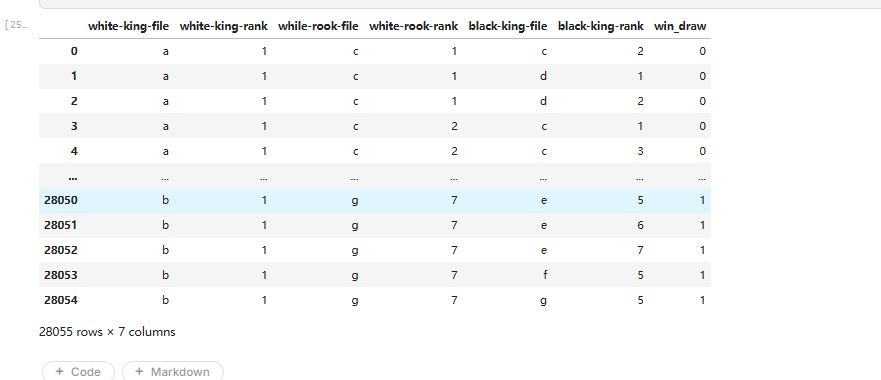
0表示和棋，其余的都表示获胜
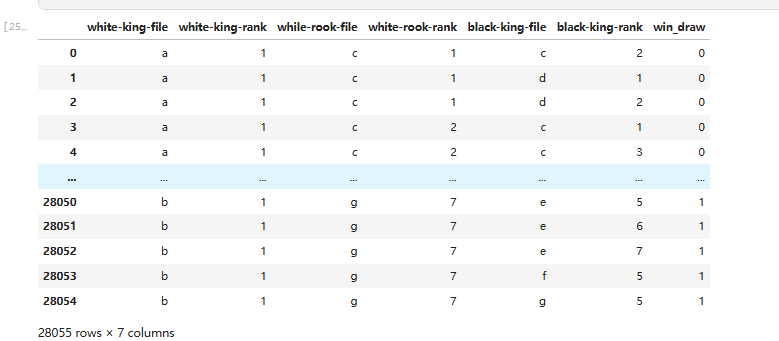

In [10]:
#接下来的数据处理就是将字母用数值代替
df['white-king-file'] = df['white-king-file'].str.lower().apply(lambda x: ord(x) - 96)
df['white-rook-file'] = df['white-rook-file'].str.lower().apply(lambda x: ord(x) - 96)
df['black-king-file'] = df['black-king-file'].str.lower().apply(lambda x: ord(x) - 96)
df

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,win_draw
0,1,1,3,1,3,2,0
1,1,1,3,1,4,1,0
2,1,1,3,1,4,2,0
3,1,1,3,2,3,1,0
4,1,1,3,2,3,3,0
...,...,...,...,...,...,...,...
28050,2,1,7,7,5,5,1
28051,2,1,7,7,5,6,1
28052,2,1,7,7,5,7,1
28053,2,1,7,7,6,5,1


#到这里我们的数据初步处理就完成了
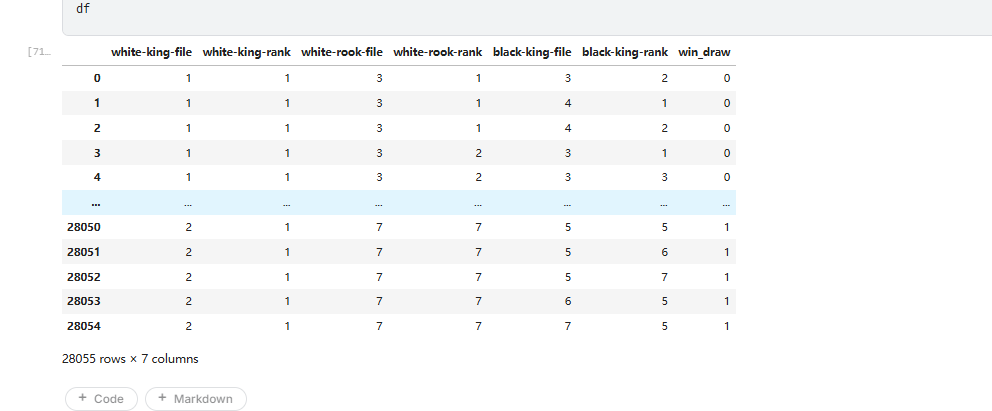
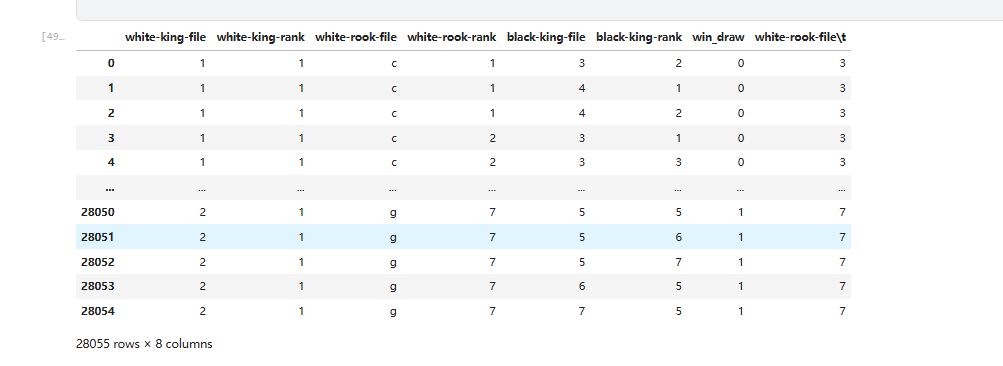

In [11]:
#数据的进一步处理
#1、归一化
#2、交叉验证

In [12]:
#数据归一化
X=df.drop('win_draw',axis=1)
y=df['win_draw']
from sklearn.preprocessing import MinMaxScaler

# 初始化归一化器
scaler = MinMaxScaler()

# 应用归一化
X_normalized = scaler.fit_transform(X)

# 转换为DataFrame
X = pd.DataFrame(X_normalized, columns=X.columns)


scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))  # 添加 .reshape(-1, 1)
y =y_normalized.ravel()  

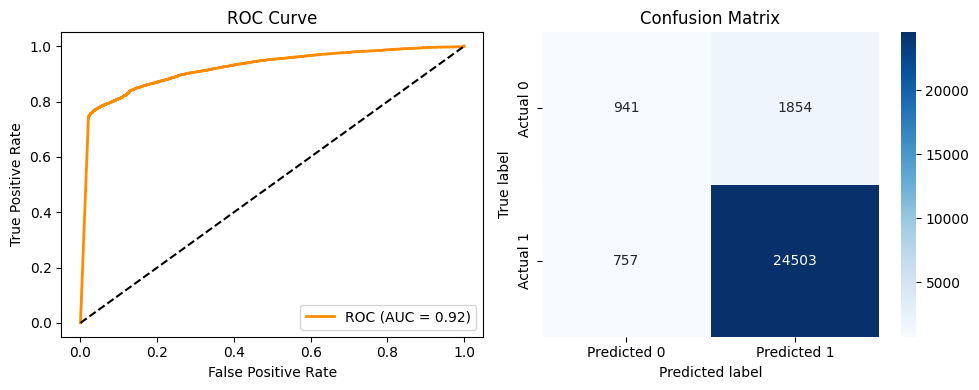

Cross-Validation Results:
Test Accuracy: 0.907 (±0.042)
Train Accuracy: 0.994 (±0.001)

Confusion Matrix:
[[  941  1854]
 [  757 24503]]


In [13]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
model= SVC(kernel='rbf', C=1, random_state=42, probability=True)


# 执行交叉验证
scores = cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=5,  # 5折交叉验证
    scoring='accuracy',  # 评估指标
    return_train_score=True,  # 返回训练集得分
    n_jobs=-1  # 使用所有CPU核心加速
)

y_pred=cross_val_predict(
    model,
    X,
    y,
    n_jobs=-1
)
y_probas = cross_val_predict(
    estimator=model,
    X=X,
    y=y,
    cv=5,
    method='predict_proba',
    n_jobs=-1
)
# ---------------------------
# 绘制ROC曲线
# ---------------------------
y_scores = y_probas[:, 1]
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# ---------------------------
# 绘制混淆矩阵
# ---------------------------
cm = confusion_matrix(y, y_pred)

plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

# ---------------------------
# 输出交叉验证结果
# ---------------------------
print("Cross-Validation Results:")
print(f"Test Accuracy: {scores['test_score'].mean():.3f} (±{scores['test_score'].std():.3f})")
print(f"Train Accuracy: {scores['train_score'].mean():.3f} (±{scores['train_score'].std():.3f})")
print("\nConfusion Matrix:")
print(cm)